## Zobraz a načítaj dostupné tabuľky

In [5]:
from keboola.component import CommonInterface
ci = CommonInterface()
input_tables = ci.get_input_tables_definitions()

for table in input_tables:
    logging.info(f'The table named: "{table.name}" is at path: {table.full_path}')

The table named: "v-product-list.csv" is at path: /data/in/tables/v-product-list.csv
The table named: "cm-stock-days-data.csv" is at path: /data/in/tables/cm-stock-days-data.csv


In [6]:
import pandas as pd
productList = pd.read_csv('/data/in/tables/v-product-list.csv')
stockDaysData = pd.read_csv('/data/in/tables/cm-stock-days-data.csv')

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


## Vyber produkty, ktoré budeme predikovať

Predikovať vyčerpanie zásob môžeme len u produktov, ktoré sú aktuálne na sklade. Dátová sada však obsahuje prípady keď 1 produkt (s daným 'entity_id_hash') zaberá viac riadkov a v stĺpci 'is_in_stock' preto môže existovať viac hodnôt. Ako však dokazuje nasledovná kontrola, tieto hodnoty sú všetky rovnaké - buď 1 alebo 0 - a preto ide zrejme o aktuálny stav na sklade.

In [7]:
productList[['entity_id_hash','is_in_stock']].groupby(['entity_id_hash']).mean()['is_in_stock'].value_counts()

0.0    5910
1.0    2883
Name: is_in_stock, dtype: int64

In [8]:
productList.shape

(54809, 14)

In [9]:
productList = productList[productList['long_term_unavaible'] == 0] # vyber dlhodobo dostupné produkty
productList = productList[productList['type_id'] == 'simple'] # vyber jednoduché (simple) produkty
productList = productList[productList['is_in_stock'] == 1] # vyčerpať zásoby môžeme len u produktov, ktoré su na sklade
productList = productList['entity_id_hash'].unique() # zaujímajú nás len unikátne produkty

productList.shape

(1848,)

Z pôvodných 54809 sme teda vyfiltrovali 1848 produktov, ktoré budeme predikovať.

## Analýza údajov o predajnosti

Cieľom bude z tabuľky cm-stock-days-data získať dáta o predajnosti produktu. Z nich následne analýzov časovej rady pomocou zvoleného modelu strojového učenia predikovať, kedy množstvo produktu klesne na 0.

In [8]:
stockDaysData.shape

(7622765, 3)

Tabuľka má cez 7 miliónov záznamov, môžeme však odstrániť dlhodobo nedostupné, konfigurovateľné a tie čo nie sú na sklade.

In [9]:
stockDaysData = stockDaysData[stockDaysData['product_id_hash'].isin(productList)]

In [10]:
stockDaysData.shape

(1351341, 3)

In [16]:
stockDaysData['period'] = stockDaysData['period'].astype('datetime64[ns]')

In [12]:
stockDaysData.head()

period                   product_id_hash   qty
0  2017-09-03  cb8a08a240f3ea7c99b220d24f54f477  67.0
15 2018-01-26  800103a4d112ae28491b249670a071ec   1.0
17 2017-09-14  587b7b833034299fdd5f4b10e7dc9fca  10.0
25 2017-09-24  ff82db7535530637af7f8a96284b3459   6.0
26 2017-10-28  a546203962b88771bb06faf8d6ec065e   2.0

In [13]:
stockDaysData['product_id_hash'].value_counts()

2f3c6a4cd8af177f6456e7e51a916ff3    1212
415185ea244ea2b2bedeb0449b926802    1212
e1dc4bf1f94e87fdfeb2d91ae3dc10ef    1212
ff1418e8cc993fe8abcfe3ce2003e5c5    1212
40dba662fae60cd3bcceaa76a82d2873    1212
                                    ... 
cb01a90256508ed990fe50e3562d0983       5
c56aa2102f060ad7471fbefe5e296c92       5
b39ac02ff5021fed10cb9988a23d5d02       5
874121fee1d3bebea38815d169d47848       4
9c8001602e98208ef4e8d1bbf79fee65       4
Name: product_id_hash, Length: 1848, dtype: int64

Niektoré produkty obsahujú príliš málo dát pre spoľahlivú predikciu.

Teraz vizualizujem predajnosť pre zopár produktov.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(30,10)})

generated new fontManager


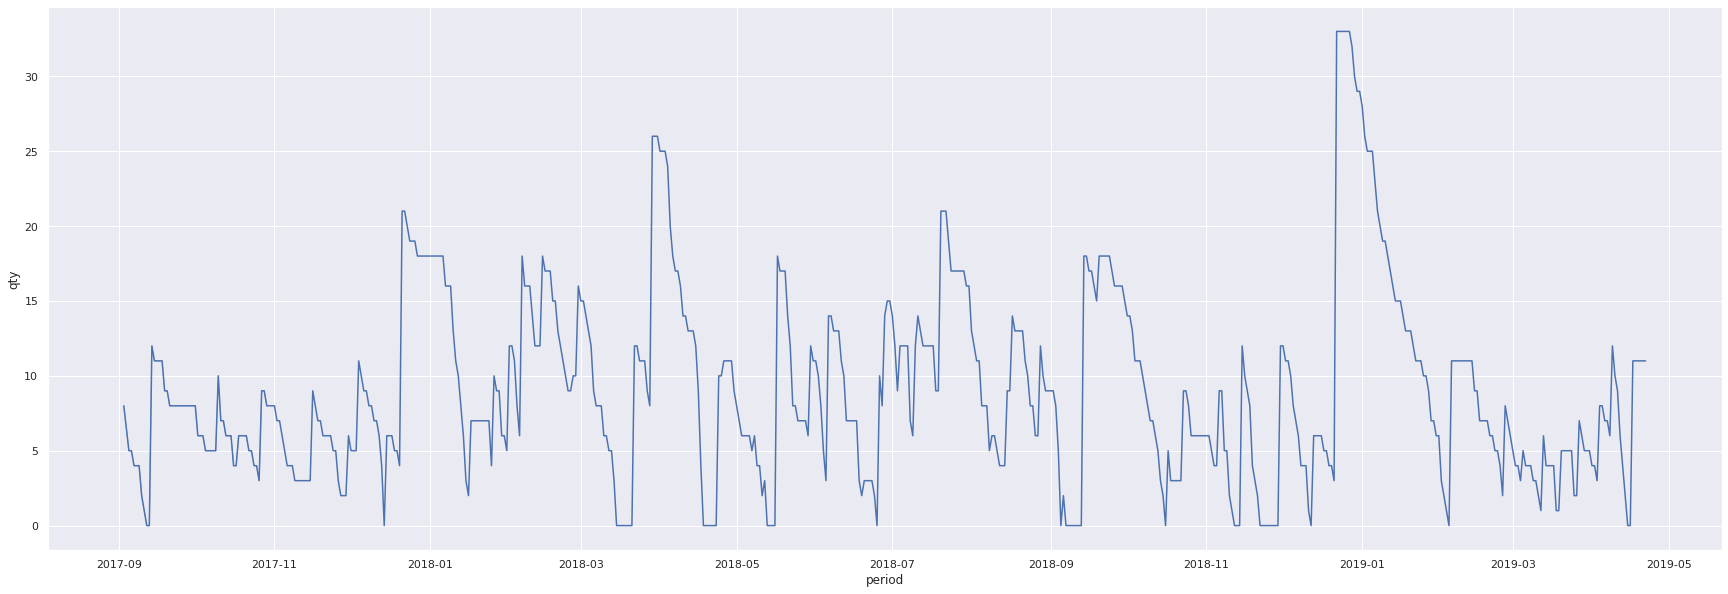

In [15]:
oneProduct = stockDaysData[stockDaysData['product_id_hash'] == '82836ca597a373e6c3cd5ae2d466161e']
sns.lineplot(x = oneProduct['period'], y = oneProduct['qty'])
plt.show()

Tento produkt ide celkom "na dračku". Zároveň nie sú väčšie problémy s doskladňovaním.

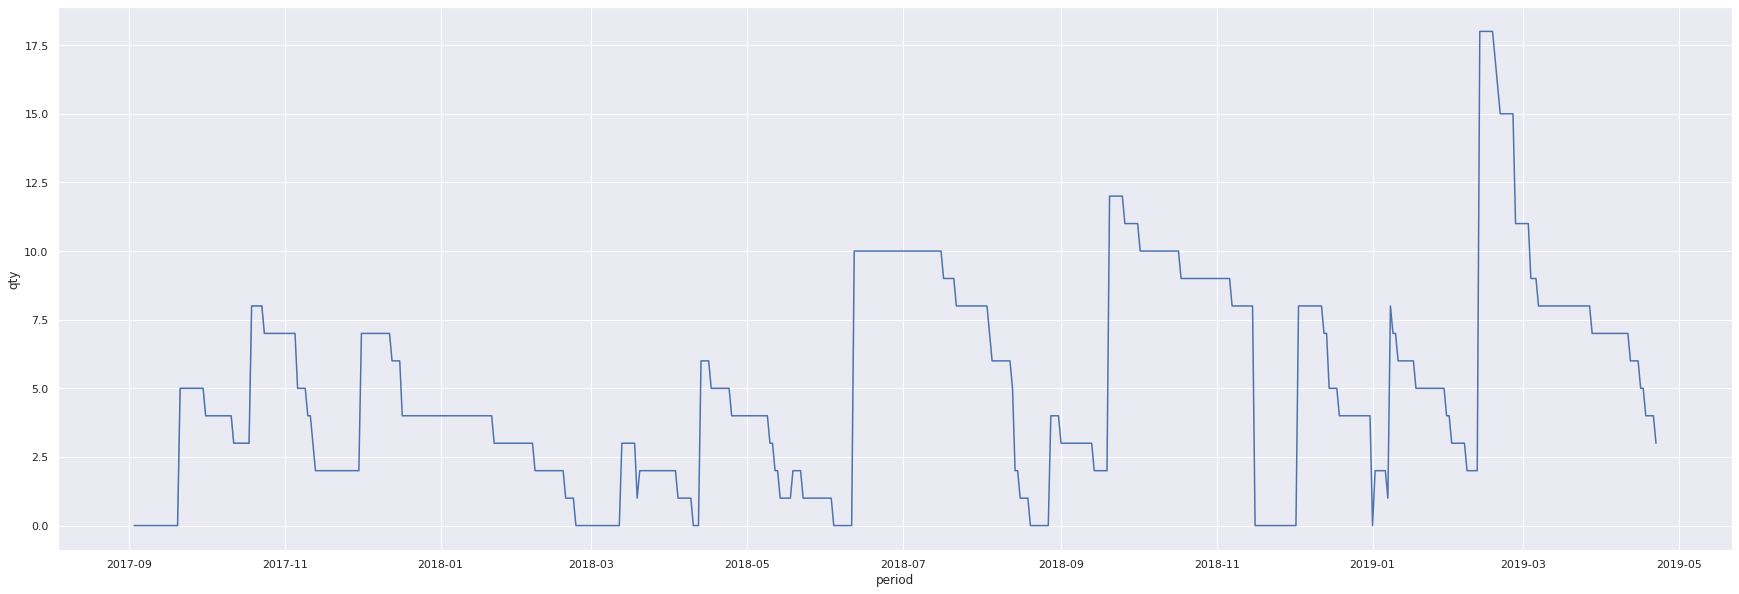

In [16]:
oneProduct = stockDaysData[stockDaysData['product_id_hash'] == '25702d4234f4c7dc542adde64426a7ca']
sns.lineplot(x = oneProduct['period'], y = oneProduct['qty'])
plt.show()

Tento produkt sa predáva horšie. Stavy keď nie je na sklade sú stále minimálne.

Údaje o predajnosti majú lineárny charakter (množstvo produktu klesá s časom) a preto sa ponúka lineárna regresia. V grafe vyššie však dochádza k doplneniu zásob, čo sú tie vertikálne čiary. To je pre nás irelevantné, preto nasledovná funkcia tieto dopĺňania eliminuje. Výsledkom je nerastúca (klesajúca/konštnantná) funkcia ktorá zachytáva ako množstvo produktu klesá.

Význam parametra ignore_out_of_stock vysvetlím neskôr.

In [12]:
import numpy as np

def get_sales(p, ignore_out_of_stock=False):
    p = p.sort_values(by=['period'])
    p.drop_duplicates()
    reversed_qty = p['qty'][::-1]
    reversed_result = []

    ground = 0
    prevq = 0

    def is_stock_refil(current_q, previous_q):
        return current_q < previous_q

    for q in reversed_qty:
        if is_stock_refil(q, prevq):
            ground += prevq

        if ignore_out_of_stock and q==0:
            pass
        else:
            reversed_result.append(ground + q)
            
        prevq = q

    return reversed_result[::-1]

Vezmime si napríklad nasledovný produkt.

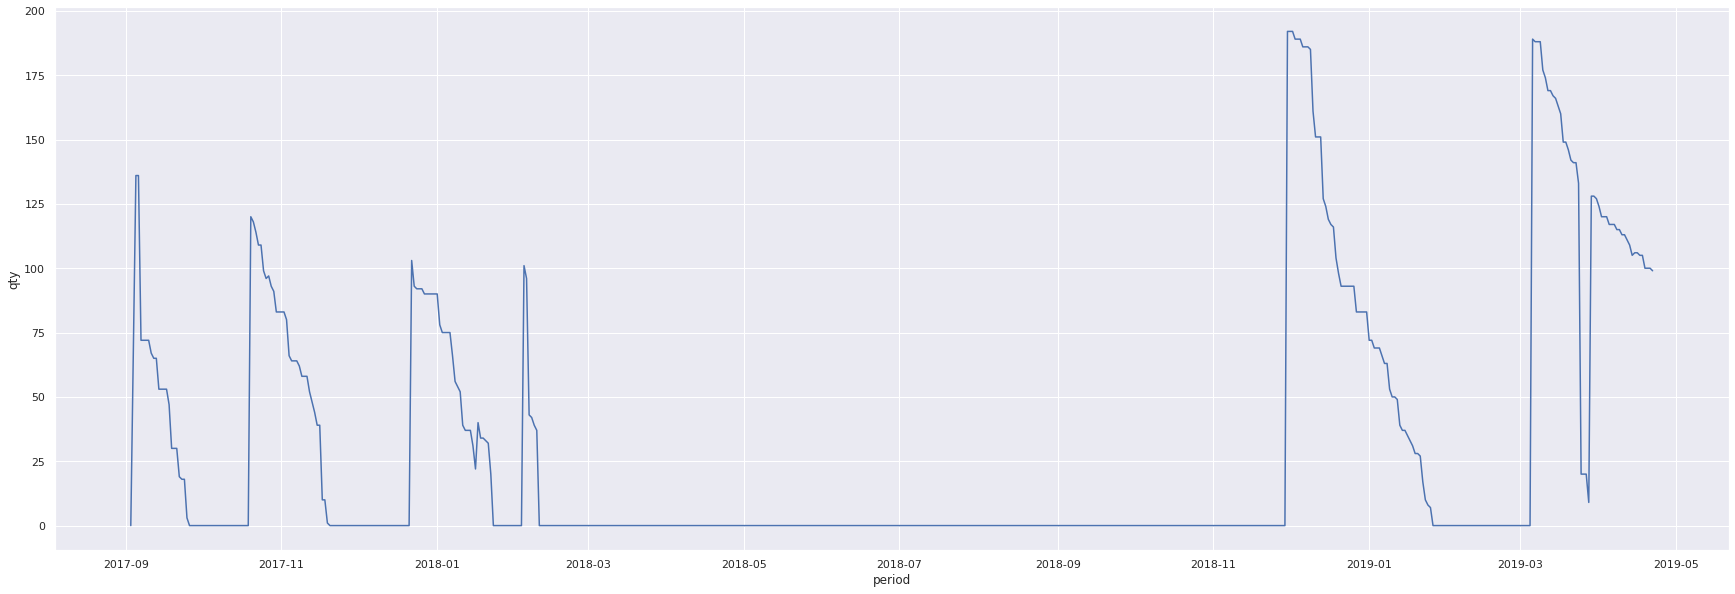

In [19]:
oneProduct = stockDaysData[stockDaysData['product_id_hash'] == '9cea886b9f44a3c2df1163730ab64994']

oneProduct = oneProduct.drop(columns='product_id_hash')
oneProduct = oneProduct.drop_duplicates()
oneProduct = oneProduct.sort_values(by=['period'])

sns.lineplot(x = oneProduct['period'], y = oneProduct['qty'])
plt.show()

Použijme get_sales() k získaniu jeho grafu predajnosti.

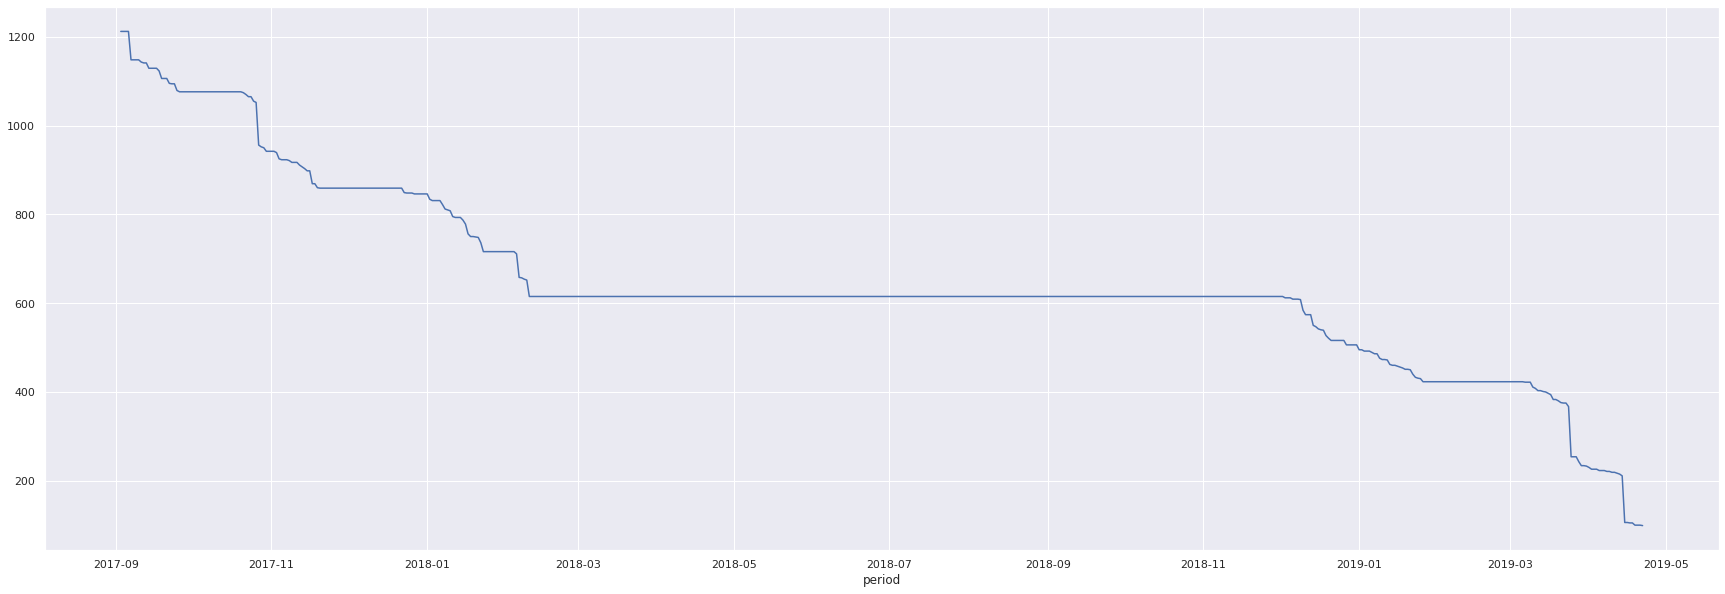

In [20]:
y_sales = get_sales(oneProduct, ignore_out_of_stock=False)
sns.lineplot(x = oneProduct['period'], y = y_sales)
plt.show()

Ako vidno, tento produkt niekoľko mesiacov nebol na sklade. To môže výrazne ovplyvniť predikciu lineárnym (alebo akýmkoľvek iným) modelom. Z hľadiska predajnosti je to však viacmenej nepodstatné - ak produkt nie je na sklade neznamená to, že oň nie je záujem. Preto som k get_sales() pridal parameter 'ignore_out_of_stock' ktorý ignoruje kvantitu z časových úsekov keď produkt nebol na sklade.

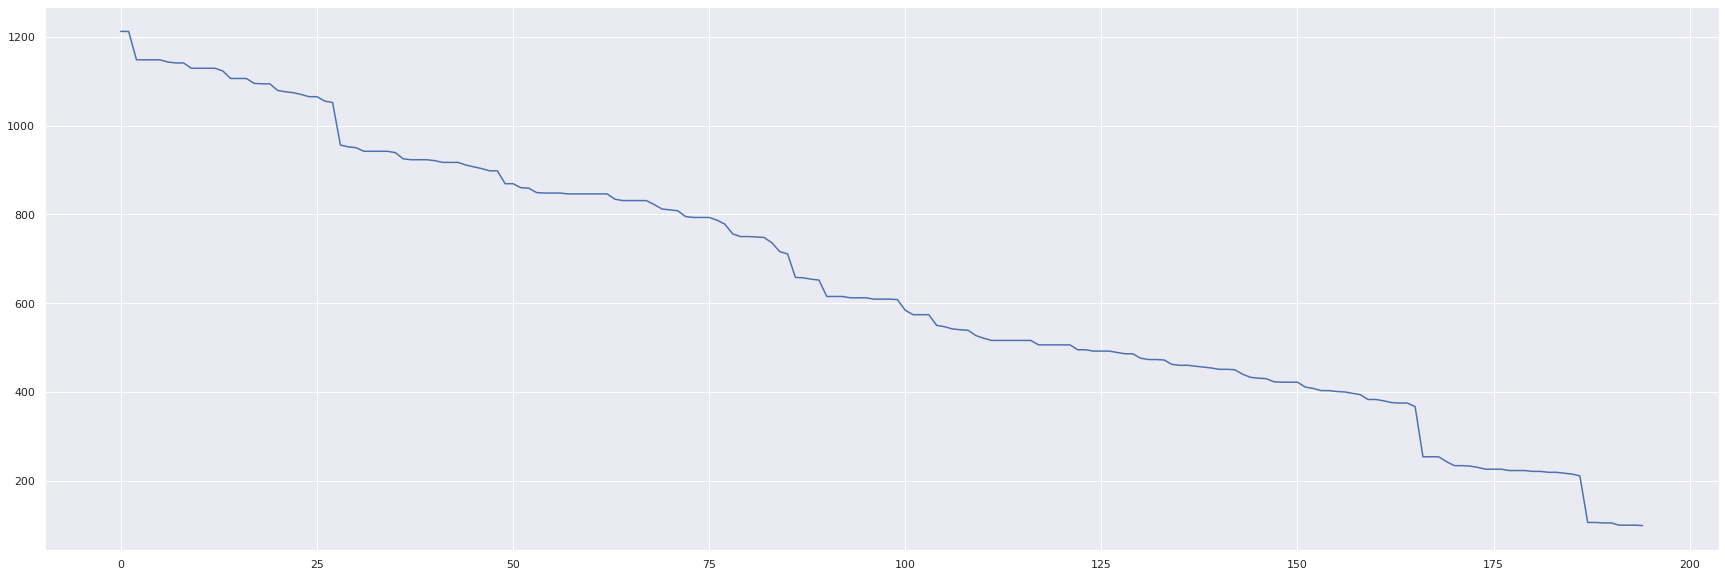

In [21]:
y_sales = get_sales(oneProduct, ignore_out_of_stock=True)
sns.lineplot(x = range(len(y_sales)), y = y_sales)
plt.show()

Rozdiel medzi odhadmi s a bez parametra ignore_out_of_stock si môžeme vizualizovať na nasledovných dvoch grafoch.

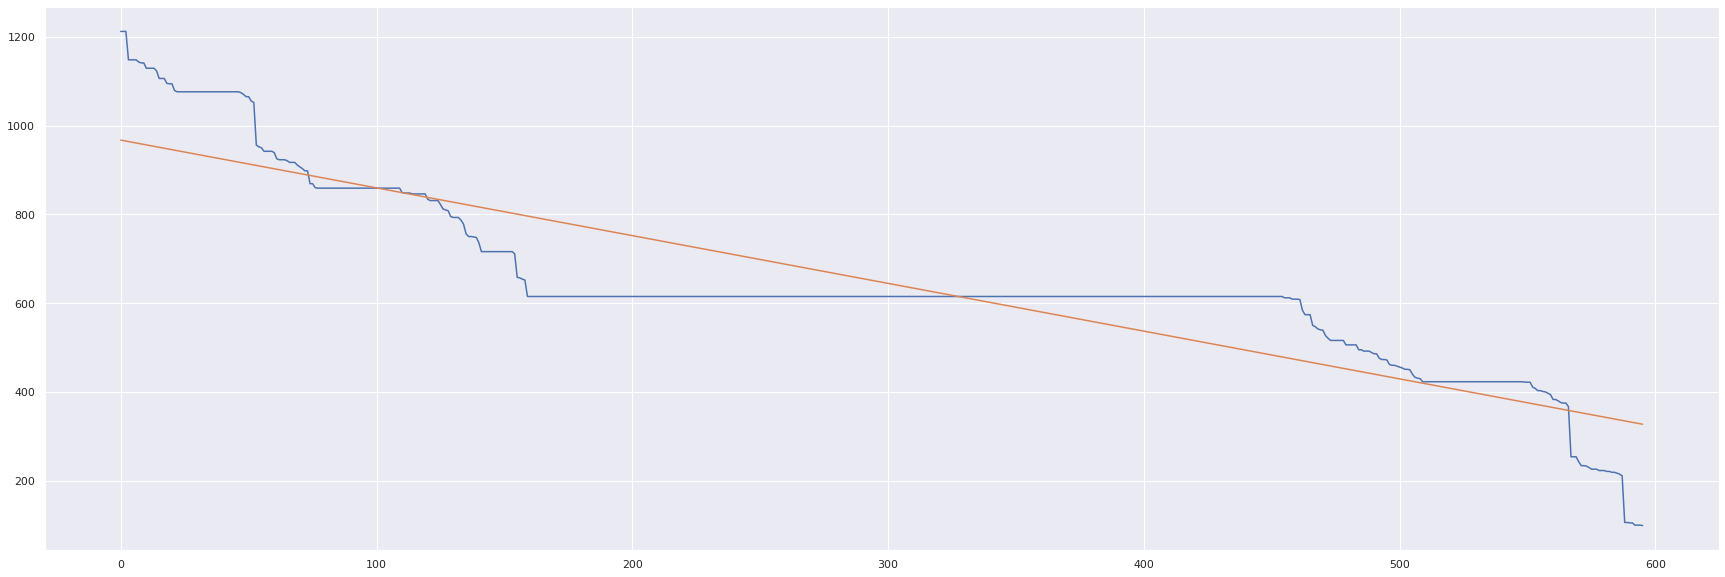

In [24]:
from sklearn.linear_model import LinearRegression

y_sales = get_sales(oneProduct, ignore_out_of_stock=False)
y = np.asarray(y_sales)
X = np.asarray(range(len(y))).reshape(-1, 1)

clf = LinearRegression()
clf.fit(X, y)

# predict on the same period
preds = clf.predict(X)
 
# plot what has been learned
plt.plot(X, y)
plt.plot(X, preds)

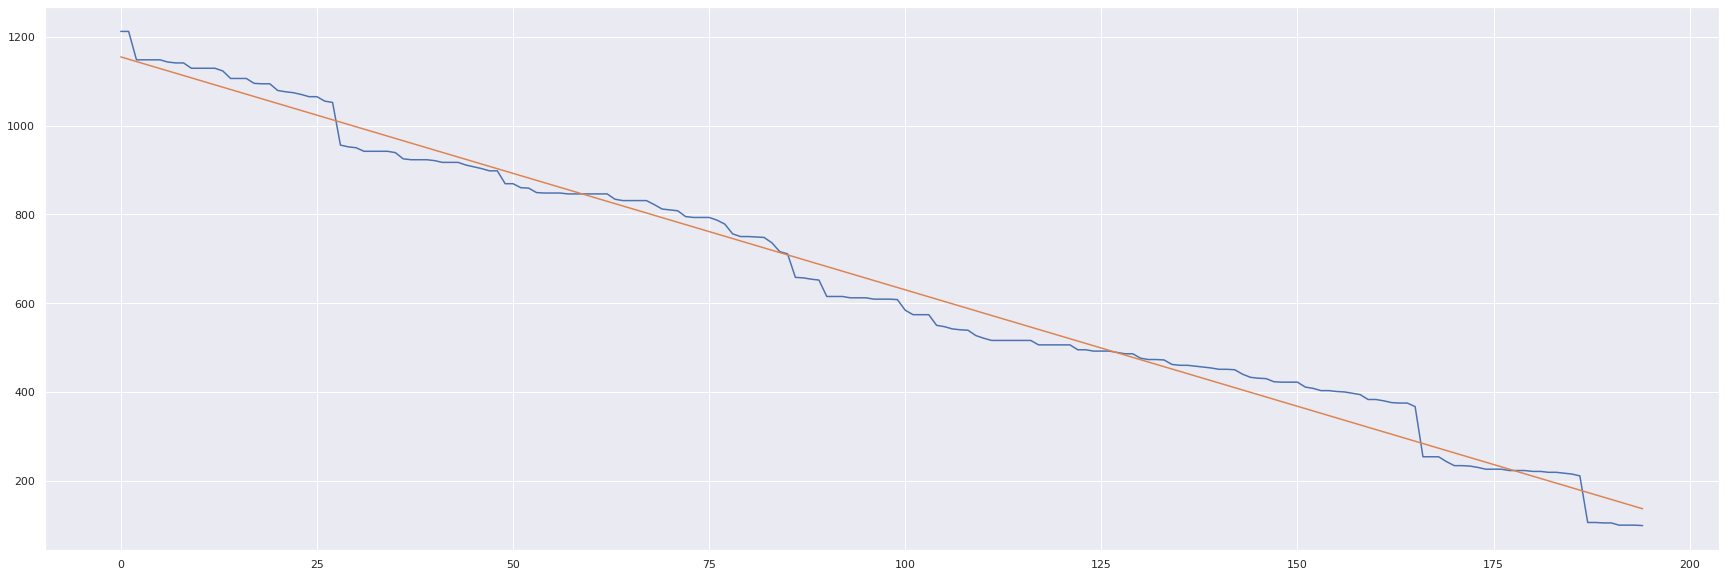

In [25]:
from sklearn.linear_model import LinearRegression

y_sales = get_sales(oneProduct, ignore_out_of_stock=True)
y = np.asarray(y_sales)
X = np.asarray(range(len(y))).reshape(-1, 1)

clf = LinearRegression()
clf.fit(X, y)

# predict on the same period
preds = clf.predict(X)
 
# plot what has been learned
plt.plot(X, y)
plt.plot(X, preds)

Použijeme teda druhý model k odhadu dňa vyčerpania zásob.

In [26]:
from sklearn.linear_model import LinearRegression

def getEstimate(product):
    y_sales = get_sales(product, ignore_out_of_stock=True)
    y = np.asarray(y_sales).reshape(-1, 1)
    X = np.asarray(range(len(y))).reshape(-1, 1)

    my_lr = LinearRegression()
    my_lr.fit(X, y)

    a = my_lr.coef_[0][0]
    b = my_lr.intercept_[0]

    today = X[-1][0]
    stockout = (-b/a).astype(int) # podla rovnice y=ax+b
    
    return stockout - today

print('Stockout expected in', getEstimate(oneProduct), 'days')

Stockout expected in 26 days


Potom som si uvedomil, že regresná priamka (oranžová) nedostatočne zohľadňuje najnovšie dáta. Ak sa produkt začal predávať viac, treba predpokladať skoršie vyčerpanie zásob a to model nezohľadňuje. Je to príliš hrubý odhad, ide to under-fitting. Vyskúšal som teda model RandomForestRegressor.

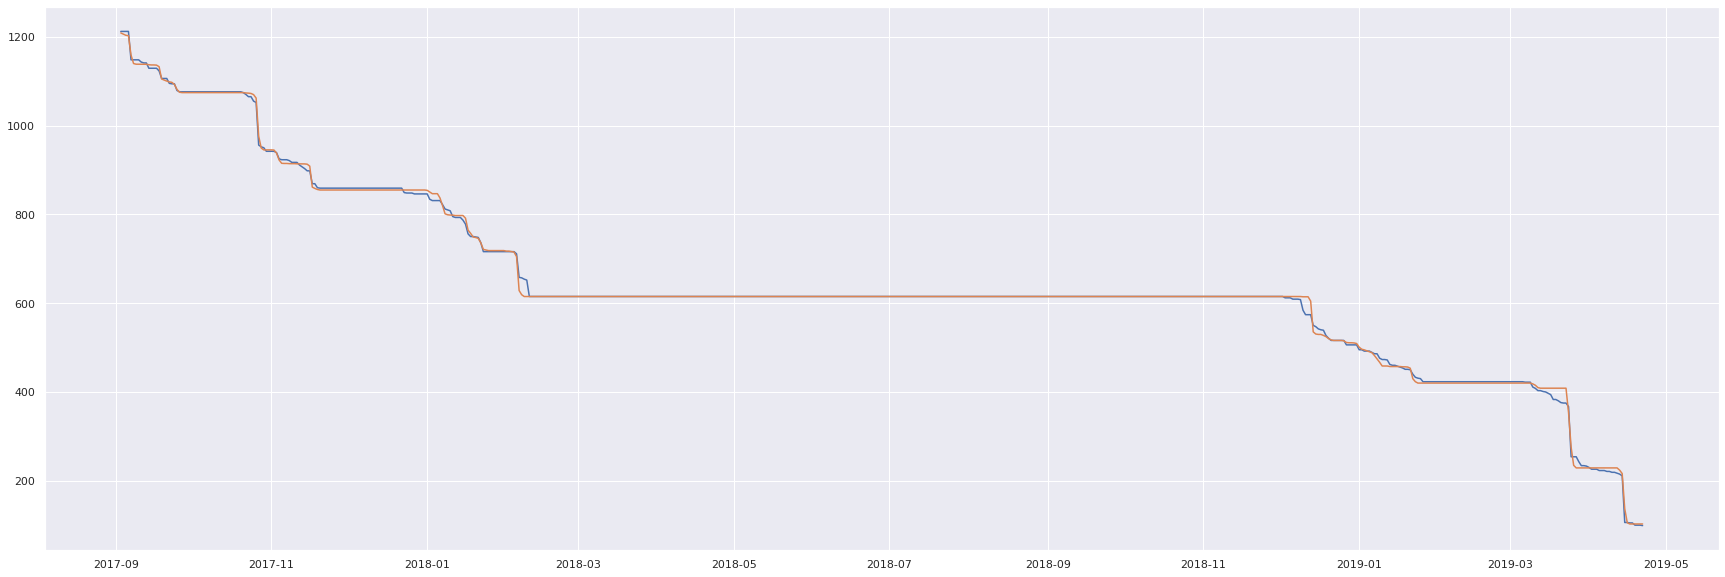

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

y_sales = get_sales(oneProduct, ignore_out_of_stock=False)
y = np.asarray(y_sales)
X = np.asarray(oneProduct['period']).reshape(-1, 1)

clf = RandomForestRegressor(max_depth = 4)
clf.fit(X, y)

# predict on the same period
preds = clf.predict(X)
 
# plot what has been learned
plt.plot(X, y)
plt.plot(X, preds)

Ako vidno, ide o over-fitting. Pokúsil som sa optimalizovať hyperparametre cez RandomizedSearchCV no narazil som na problém krosvalidácie. Ide o časovú radu a tak nemožno Ľubovoľne rozdeliť dáta na train a test set. Je nutné použiť sklearn.model_selection.TimeSeriesSplit no už som ho nestihol naštudovať. Napadlo mi jednoduchšie riešenie odhadu a tak som tento smer opustil. 

## Finálne riešenie

Táto kapitola popisuje riešenie, ktoré som nakoniec použil na odhad.

Tu je graf predajnosti produktu, ktorý odhadujeme, spolu s jeho lineárnou aproximáciou.

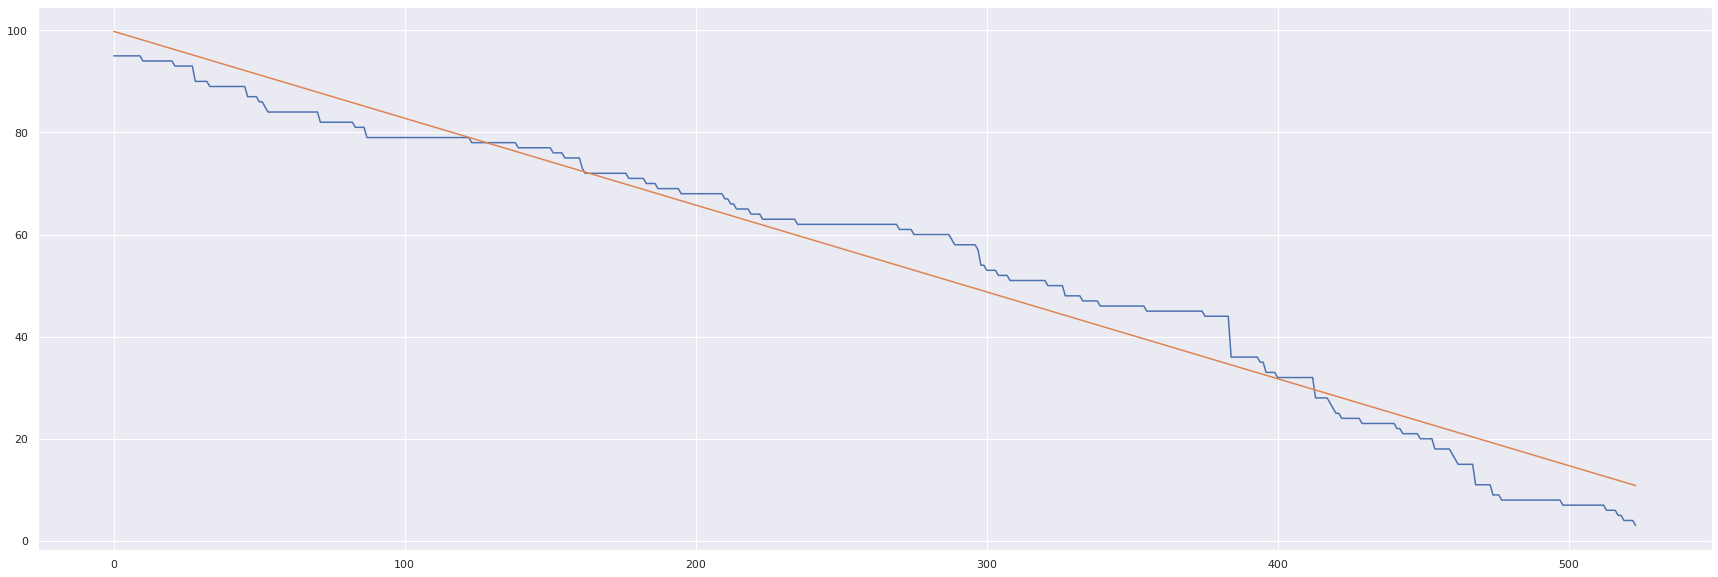

In [21]:
from sklearn.linear_model import LinearRegression
import datetime

p = stockDaysData[stockDaysData['product_id_hash'] == '25702d4234f4c7dc542adde64426a7ca']
p = p.drop_duplicates()
p = p.sort_values(by=['period'])
    
clf = LinearRegression()
    
y_sales = get_sales(p, ignore_out_of_stock=True)
y = np.asarray(y_sales)
X = np.asarray(range(len(y))).reshape(-1, 1)
    
clf.fit(X, y)
preds = clf.predict(X)

plt.plot(X, y)
plt.plot(X, preds)

Namiesto regresnej priamky som k odhadu použil počet kusov produktu predaný za tú časť obdobia, po ktorú sa produkt reálne dal zakúpiť.

In [37]:
def get_sales_rate(y):
    full_qty = y[0]
    curr_qty = y[-1]
    days = len(y)
    return (full_qty - curr_qty) / days

sales_rate = get_sales_rate(y)
sales_rate

0.17557251908396945

In [38]:
curr_qty = y[-1]
daysToNextStockout = round(curr_qty / sales_rate)

daysToNextStockout

17

In [39]:
nextStockout = p['period'].max() + pd.Timedelta(days=daysToNextStockout)
nextStockout

Timestamp('2019-05-09 00:00:00')

In [40]:
print('Today is day', p['period'].max())
print('Stockout expected in', daysToNextStockout, 'days')
print('Stockout is expected at day', nextStockout)

Today is day 2019-04-22 00:00:00
Stockout expected in 17 days
Stockout is expected at day 2019-05-09 00:00:00


Produkt sa teda vyčerpá za 17 dní, v grafe som označil červeno bodkou.

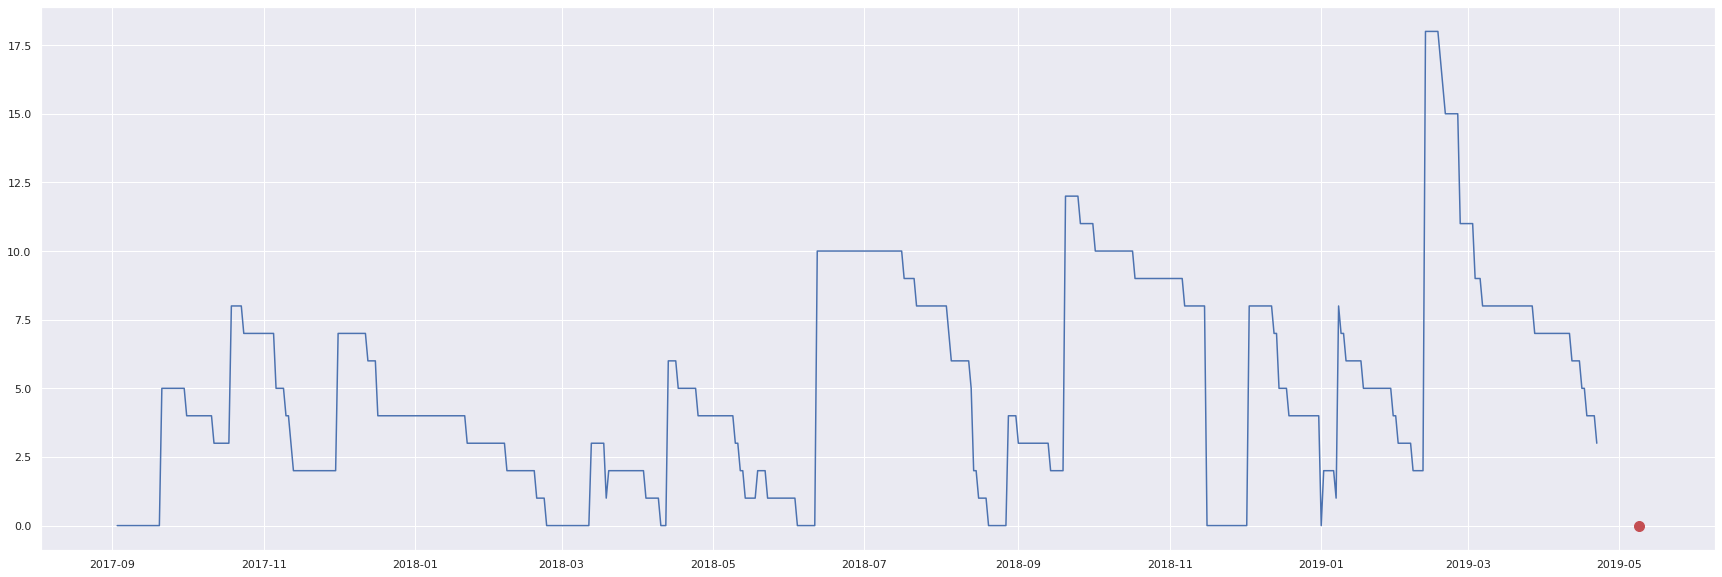

In [41]:
plt.plot(p['period'], p['qty'])
plt.plot(nextStockout,0, 'ro', markersize=10)

Teraz sa pokúsim zistiť ako by dopadol odhad ak by som uvažoval len novšie údaje o predajnosti. Budem uvažovať len tú novšiu polovicu z predošlých údajov o predajnosti - približne obdobie od 2018-07 do súčasnosti. 

In [42]:
sales_rate_emphasize_recent = get_sales_rate(y[len(y)//2:])
sales_rate_emphasize_recent

0.22519083969465647

In [43]:
curr_qty = y[-1]
daysToNextStockout_emphasize_recent = round(curr_qty / sales_rate_emphasize_recent)

daysToNextStockout_emphasize_recent

13

In [44]:
nextStockout_emphasize_recent = p['period'].max() + pd.Timedelta(days=daysToNextStockout_emphasize_recent)
nextStockout_emphasize_recent

Timestamp('2019-05-05 00:00:00')

Novší odhad som označil zelenou bodkou. Ako vidno, predaj produktu v poslednej dobe zrýchlil a tak sa predpokladá skoršie vyčerpanie zásob.

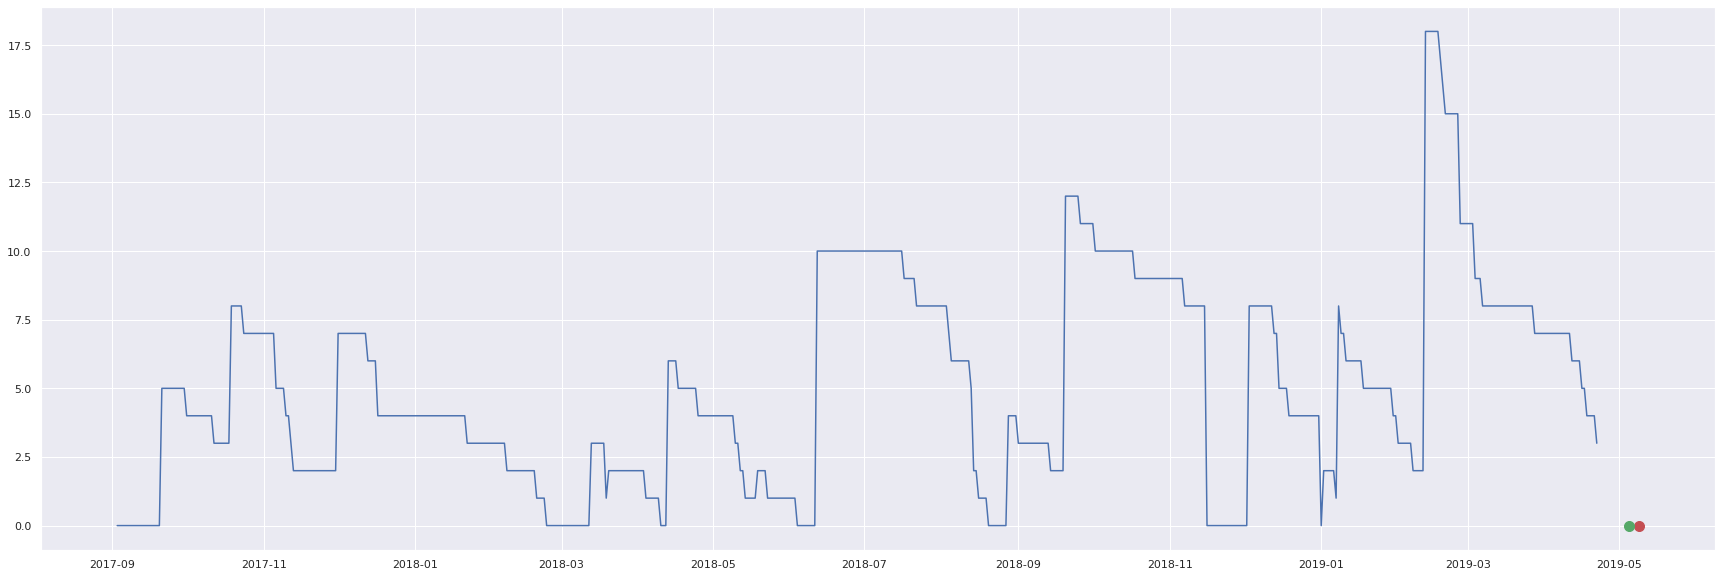

In [45]:
plt.plot(p['period'], p['qty'])
plt.plot(nextStockout,0, 'ro', markersize=10)
plt.plot(nextStockout_emphasize_recent,0, 'go', markersize=10)

Vytvoril som funkciu pre postup výpočtu odhadu.

In [46]:
def get_next_stockout(p, emphasize_recent=False):
    p = p.drop_duplicates()
    p = p.sort_values(by=['period'])
    
    y = get_sales(p, ignore_out_of_stock=True)
    X = range(len(y))

    if emphasize_recent:
        y = y[len(y)//2:]
    
    sales_rate = get_sales_rate(y)
    curr_qty = y[-1]
    daysToNextStockout = round(curr_qty / sales_rate)
    
    return p['period'].max() + pd.Timedelta(days=daysToNextStockout)

get_next_stockout(p, emphasize_recent=True)

Timestamp('2019-05-05 00:00:00')

Následuje ešte jeden príklad produktu, kde má zmysel uprednostniť novšie dáta. Ak mám málo údajov, ako v nasledovnom prípade, všetky historické dáta by mi predpovedali pravú (červenú) hodnotu. Rozumnejšie je však asi predpokladať skoršie vyčerpanie zásob (zelená), lebo v posledných dňoch predajnosť vzrástla. Rozdiel pritom činí viac než 1 mesiac.

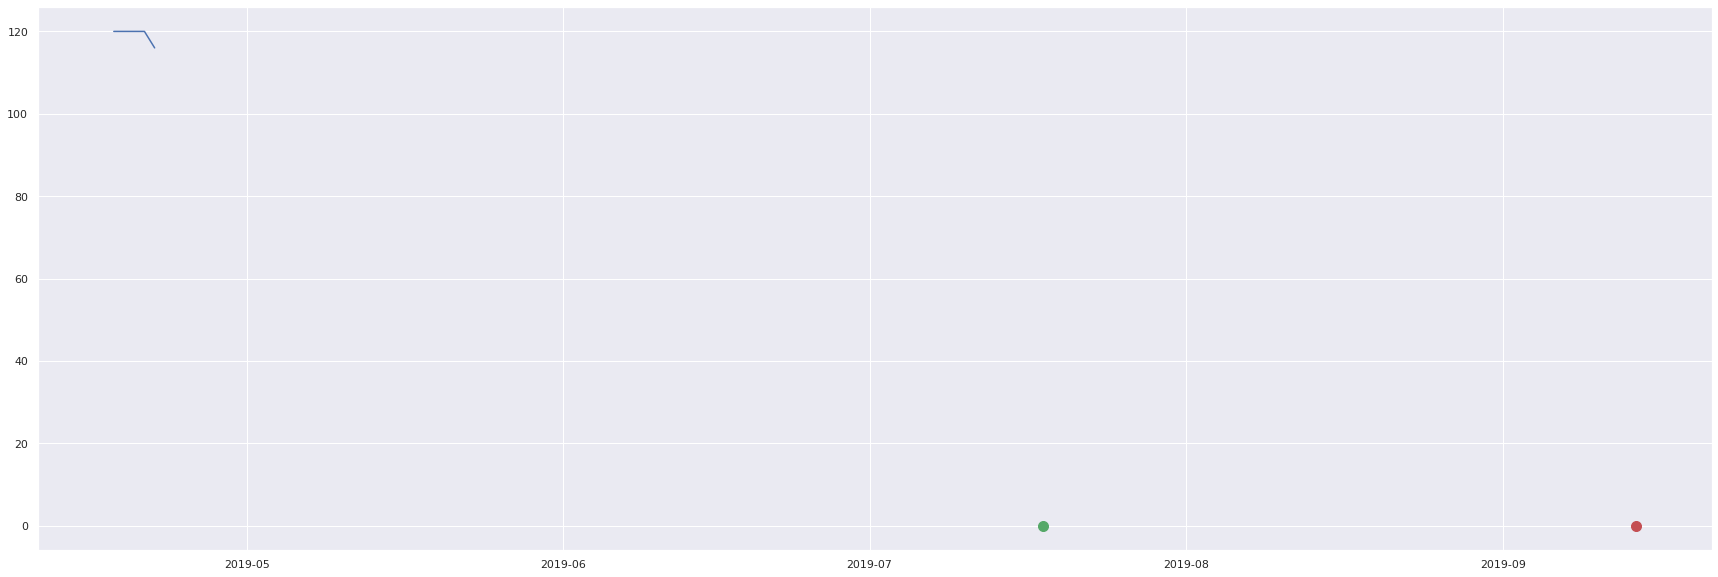

In [47]:
p = stockDaysData[stockDaysData['product_id_hash'] == 'cb01a90256508ed990fe50e3562d0983']
p = p.drop_duplicates()
p = p.sort_values(by=['period'])

plt.plot(p['period'], p['qty'])
plt.plot(get_next_stockout(p, emphasize_recent=False), 0, 'ro', markersize=10)
plt.plot(get_next_stockout(p, emphasize_recent=True), 0, 'go', markersize=10)

Následuje už len výpočet odhadu pre každý z odhadovaných produktov a export výsledkov do CSV.

In [99]:
df = pd.DataFrame([], columns = ['product_id_hash', 'expected_stockout'])
remaining = len(productList)

for product_id_hash in productList:
    print('adding product', product_id_hash)
    
    try:
        p = stockDaysData[stockDaysData['product_id_hash'] == product_id_hash]

        p = p.drop(columns='product_id_hash')
        p = p.drop_duplicates()
        p = p.sort_values(by=['period'])

        df = df.append({'product_id_hash': product_id_hash, 'expected_stockout': get_next_stockout(p)}, ignore_index=True)
        
        print('success!')
        print('remaining products: ', remaining, '\n')
    except:
        print('unknown error, skipping product')
        
    remaining-=1


adding product 072b030ba126b2f4b2374f342be9ed44
success!
remaining products:  1848 

adding product 32bb90e8976aab5298d5da10fe66f21d
success!
remaining products:  1847 

adding product e00da03b685a0dd18fb6a08af0923de0
success!
remaining products:  1846 

adding product 1d7f7abc18fcb43975065399b0d1e48e
success!
remaining products:  1845 

adding product 8c19f571e251e61cb8dd3612f26d5ecf
success!
remaining products:  1844 

adding product 94f6d7e04a4d452035300f18b984988c
success!
remaining products:  1843 

adding product f2fc990265c712c49d51a18a32b39f0c
success!
remaining products:  1842 

adding product f9b902fc3289af4dd08de5d1de54f68f
success!
remaining products:  1841 

adding product 01386bd6d8e091c2ab4c7c7de644d37b
success!
remaining products:  1840 

adding product 46922a0880a8f11f8f69cbb52b1396be
success!
remaining products:  1839 

adding product a532400ed62e772b9dc0b86f46e583ff
success!
remaining products:  1838 

adding product 303ed4c69846ab36c2904d3ba8573050
success!
remainin

In [101]:
df.to_csv('/data/out/tables/output.csv', index=False)

Nakoniec pridávam aj odhady pre prípad, že uvažujeme len novšiu polovicu z historických dát o predajnosti.

In [102]:
df_emphasize_recent = pd.DataFrame([], columns = ['product_id_hash', 'expected_stockout'])

for product_id_hash in productList:
    try:
        p = stockDaysData[stockDaysData['product_id_hash'] == product_id_hash]

        p = p.drop(columns='product_id_hash')
        p = p.drop_duplicates()
        p = p.sort_values(by=['period'])

        df_emphasize_recent = df_emphasize_recent.append({'product_id_hash': product_id_hash, 'expected_stockout': get_next_stockout(p, emphasize_recent=False)}, ignore_index=True)
    except:
        pass

df.to_csv('/data/out/tables/output_emphasize_recent.csv', index=False)

Do budúcna by som vyskúšal niektorý z pokročilejších modelov pre analýzu časových rád.

- https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1
- https://towardsdatascience.com/forecasting-of-periodic-events-with-ml-5081db493c46
- https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html